# Introduction
This lab is aim at building a light-weighted CNN model called [EEGNet](https://arxiv.org/pdf/1611.08024.pdf), which is designed for classification problem on EEG. EEGNet is inspired by Xception and uses depthwise separable convolution instead of 3x3 convolution filter to capture features and to decrease parameters. EEGNet is still the state-of-the-art in EEG classification problem. We have presented this work at CECNL Lab. See more details at: https://drive.google.com/drive/u/0/folders/1Ef3YyY0x3e3jV3QRW-s4h_GGUHSjQVpb

## EEG paradigm
Both training and testing data are extracted from BCI Competition III - IIIb Cued motor imagery with online feedback (nonstationary classifier) with 2 classes (left hand, right hand) from 3 subjects [2 classes, 2 bipolar EEG channels]
* Reference: http://www.bbci.de/competition/iii/desc_IIIb.pdf
* The processed data including 2 channels, each including 1080 records and 750 timestamps
* Take one record as example:
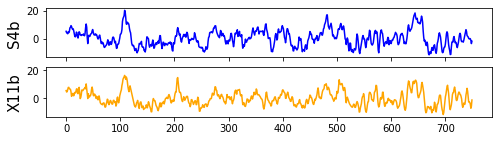

## Depthwise Separable Convolution
This technique is proposed by Xception, which is followed by Inception.
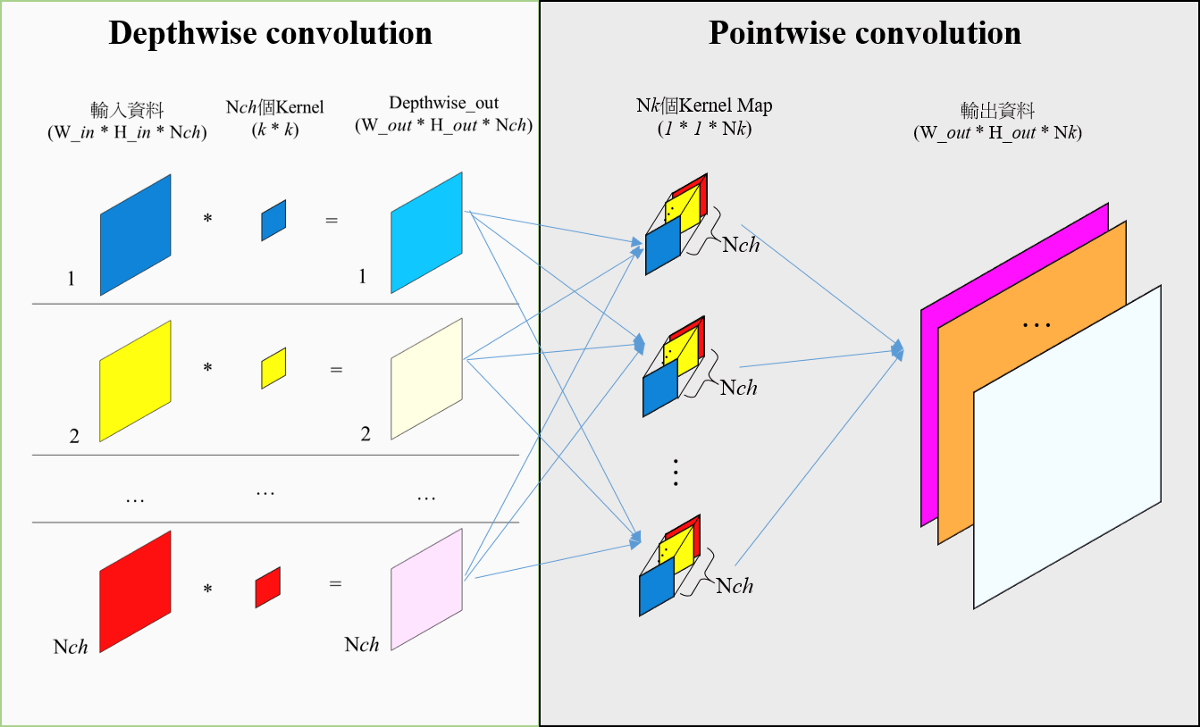 

### Low rank approximation
We could also see Depthwise Separable convolution in Linear Algebra or Low rank approximation aspects.

#### Rank-1 Matrix Decomposition
Considering a n by n convolution filter as a matrix, and we could apply rank-1 matrix decomposition on a matrix and get the sum of outer products of n by 1 vectors. These kind of n by 1 vectors could be regarded as depthwise and pointwise convolution filters. If we replace the n by n convolution filters with these rank-1 vectors, we could decrease the parameters from n^2 to 2n. Obviously, this kind of parameter reduction might decrease the capability of models.
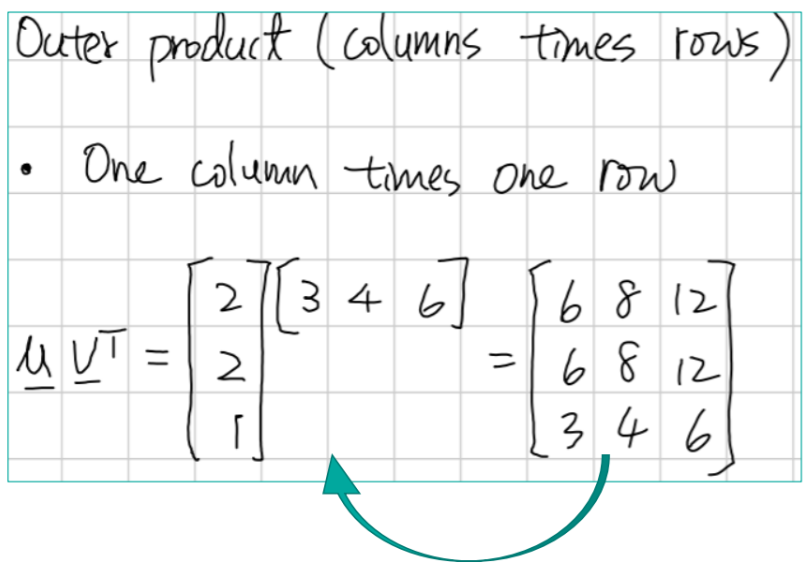
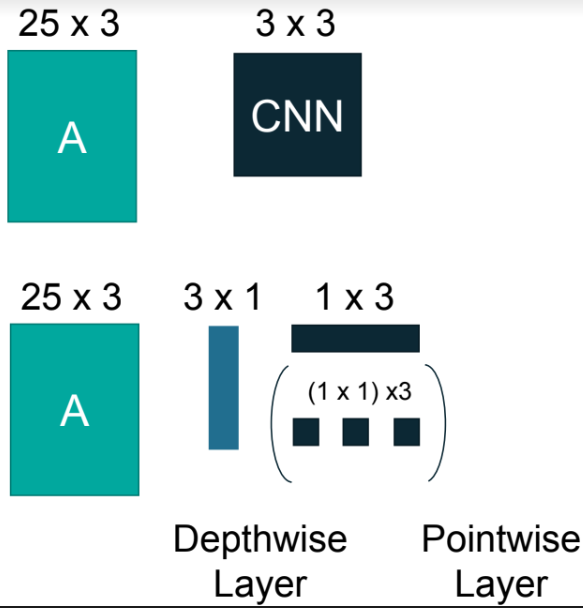

#### Rank-1 Tensor Decomposition
We often use high dimensional convolution filters in Computer Vision, and we need tensors for representing those high dimensional filters. Rank-1 decomposition for tensor is an optimization problem, and we could take this as extention of singular value decomposition in high dimensional domain.
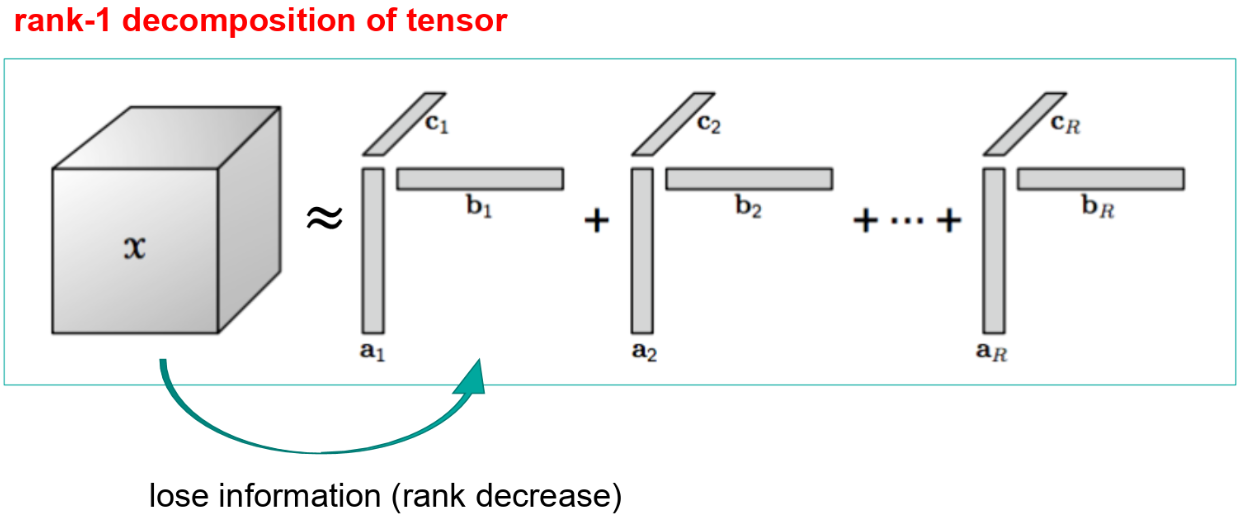

* Practically, some deep learning frameworks like keras have implemented **separable layers** which combines depthwise convolution and pointwise convolution together, which is a depthwise layer and immediately follows by a pointwise convolution layer. We would use "separable convolution" as a term later.

* Ref: https://medium.com/@chih.sheng.huang821/%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-mobilenet-depthwise-separable-convolution-f1ed016b3467

# Experimental Setup
We compare EEGNet with a Deep Convolution Network mentioned in EEGNet paper. 

## EEGNet architechture

* My EEGNet has the same neurons and layers with TA's EEGNet
    * Our architecture has different number of neurons with original paper, I guess TA took differenet some EEG data with different sample rate.
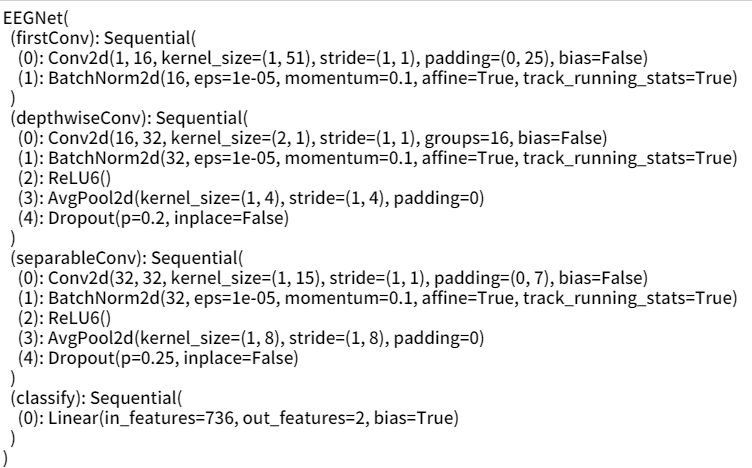

## DeepConvNet architechture
* C = 2, T = 750 and N = 2.
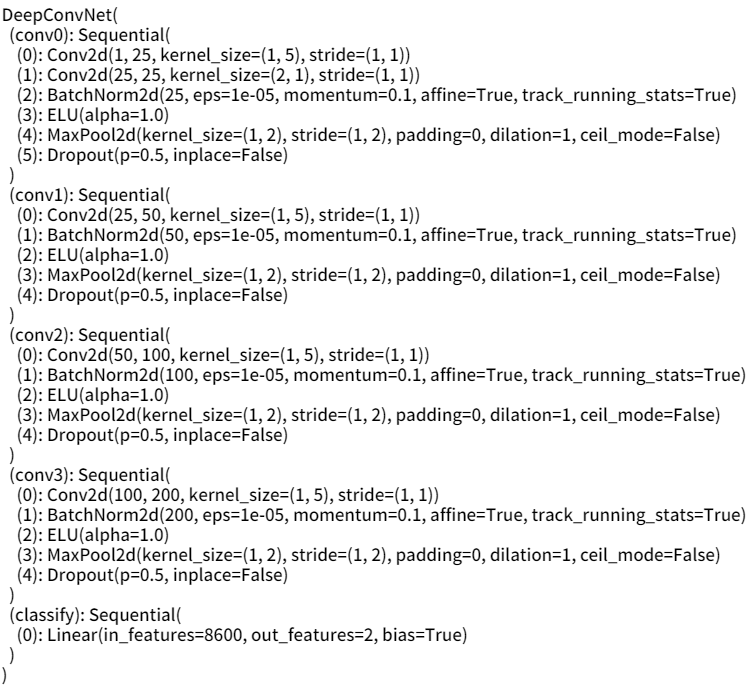

# EEGNet Details
## Activation Function
### ELU
$ELU(x) = max(0,x) + min(0, \alpha (e^x-1))$

ELU is mentioned in many papers using depthwise separable convolution like Xception, MobileNetV2, and also EEGNet. Most of these works pointed out that ReLU might much more easily suffer from the "dead neuron" problem due to smaller sizes of depthwise and pointewise layers. They recommended that it is better to use ELU activation right after pointwise convolution.

However, in my experiments, ELU performed the worst in all activation functions. I guess the reason about this phenomenon is that our dataset is so small that EEGNet does not need to learn weights in sparse space to represent the information of whole training data. Without sparsity of weights, the dead neuron problem would not be too harmful.


### ReLU
ReLU gives good enough results.

### ReLU6
Some empirical results found that clipping mechanism for ReLU function could make training process much more stable and get better accuracy.
Ref: https://arxiv.org/pdf/1803.08607.pdf
Ref: https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf

### Leaky ReLU
Not bad, but dead neurons problem didn't happen harmfully in our network so that Leaky ReLU did not outperform ReLU and ReLU6


## Default Hyperparameters
* Batch size= 64
* Learning rate = 0.0025
* Epochs = 300
* Optimizer: Adam 
* Loss function: torch.nn.CrossEntropyLoss() 

# Experimental results
## Highest accuracy
* EEGNet (default dropout rate)
    * I tried different dropoute rates at discussion part
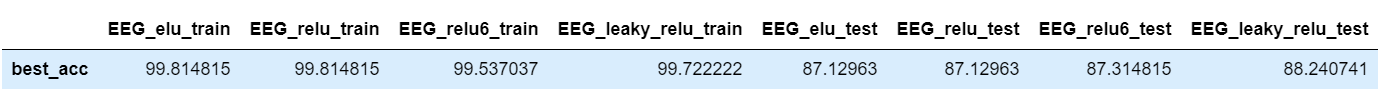
* DeepConvNet
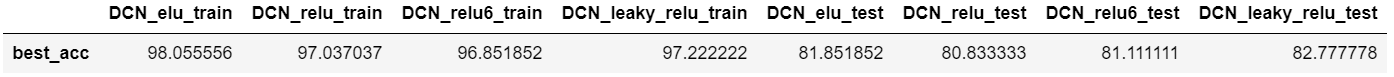

## Result Comparison
There is a black dotted line at 87%
* EEGNet
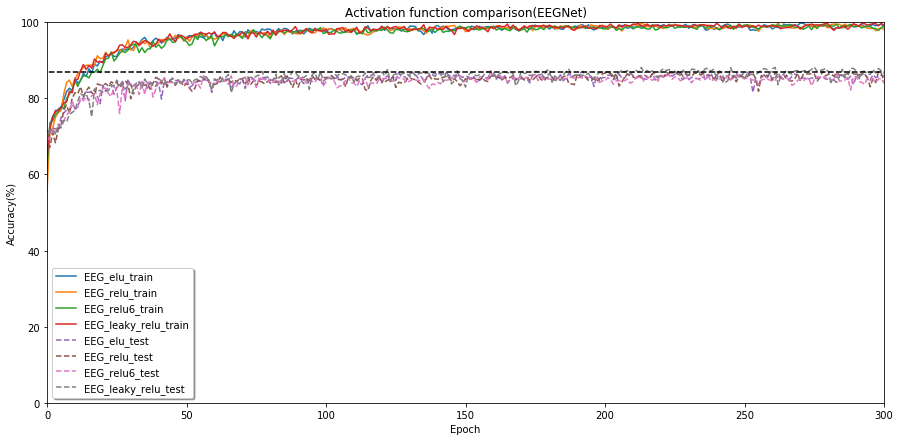
* DeepConvNet
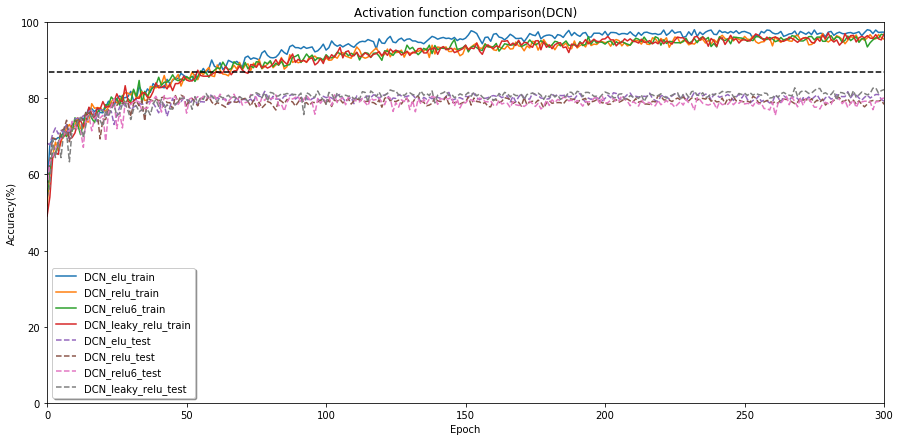

# Discussion and extra experiments

## Hyperparameter Tuning
Hyperparameter Tuning is only applied to EEGNet because EEGNet is much more pratical then the DeepConvNet, and there are less parameter in EEGNet so that this tuning process could be faster.

* Though dropout rates don't belong to hyperparameters, I tried to tune dropout rates together to see whether it could improve accuracy

### [Ray Tune](https://github.com/ray-project/ray/blob/ray-0.3.1/doc/source/tune.rst)
[Ray Tune](https://arxiv.org/abs/1807.05118) is a state-of-the-art distributed hyperparameter tuning framework, supporting many famous tuning algorithm including grid search, [Population Based Training (PBT)](https://arxiv.org/abs/1711.09846), and also supporting some early stopping algorithm like [Asynchronous Successive Halving. Algorithm (ASHA)](https://arxiv.org/abs/1810.05934)

* Using Early stopping algorithm often stops too early to get better accuracy, so I omit this.
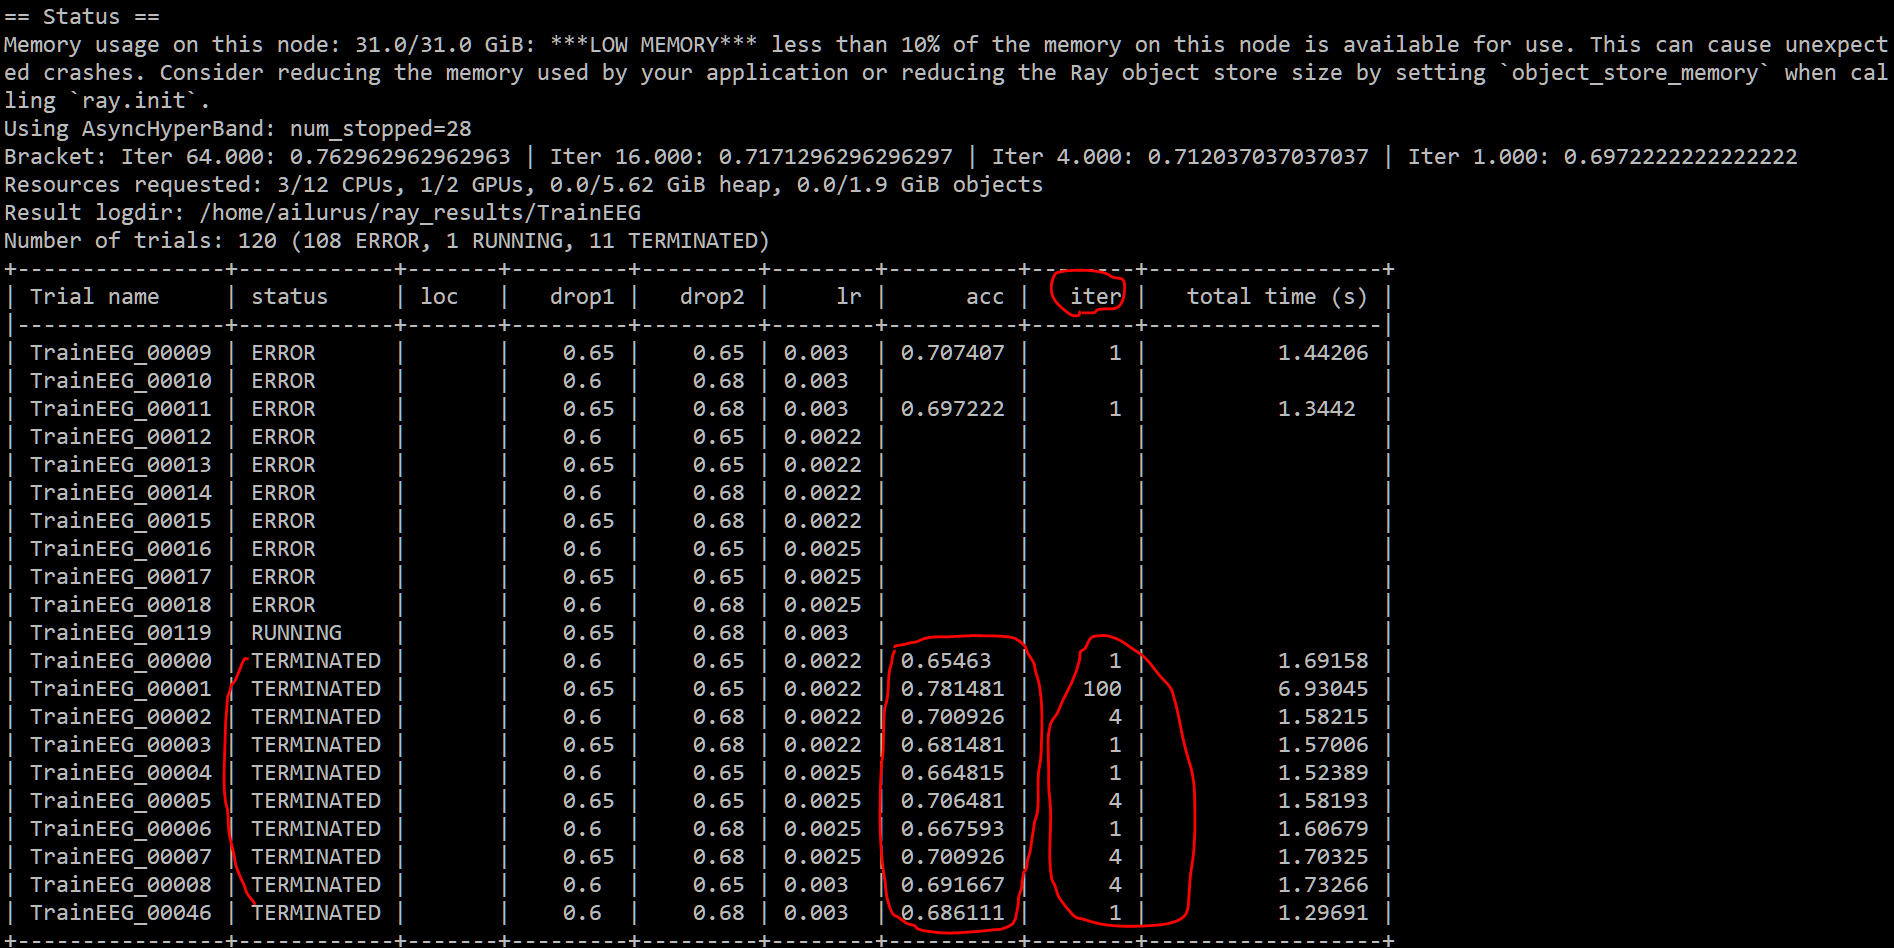

* Ray Tune running Example
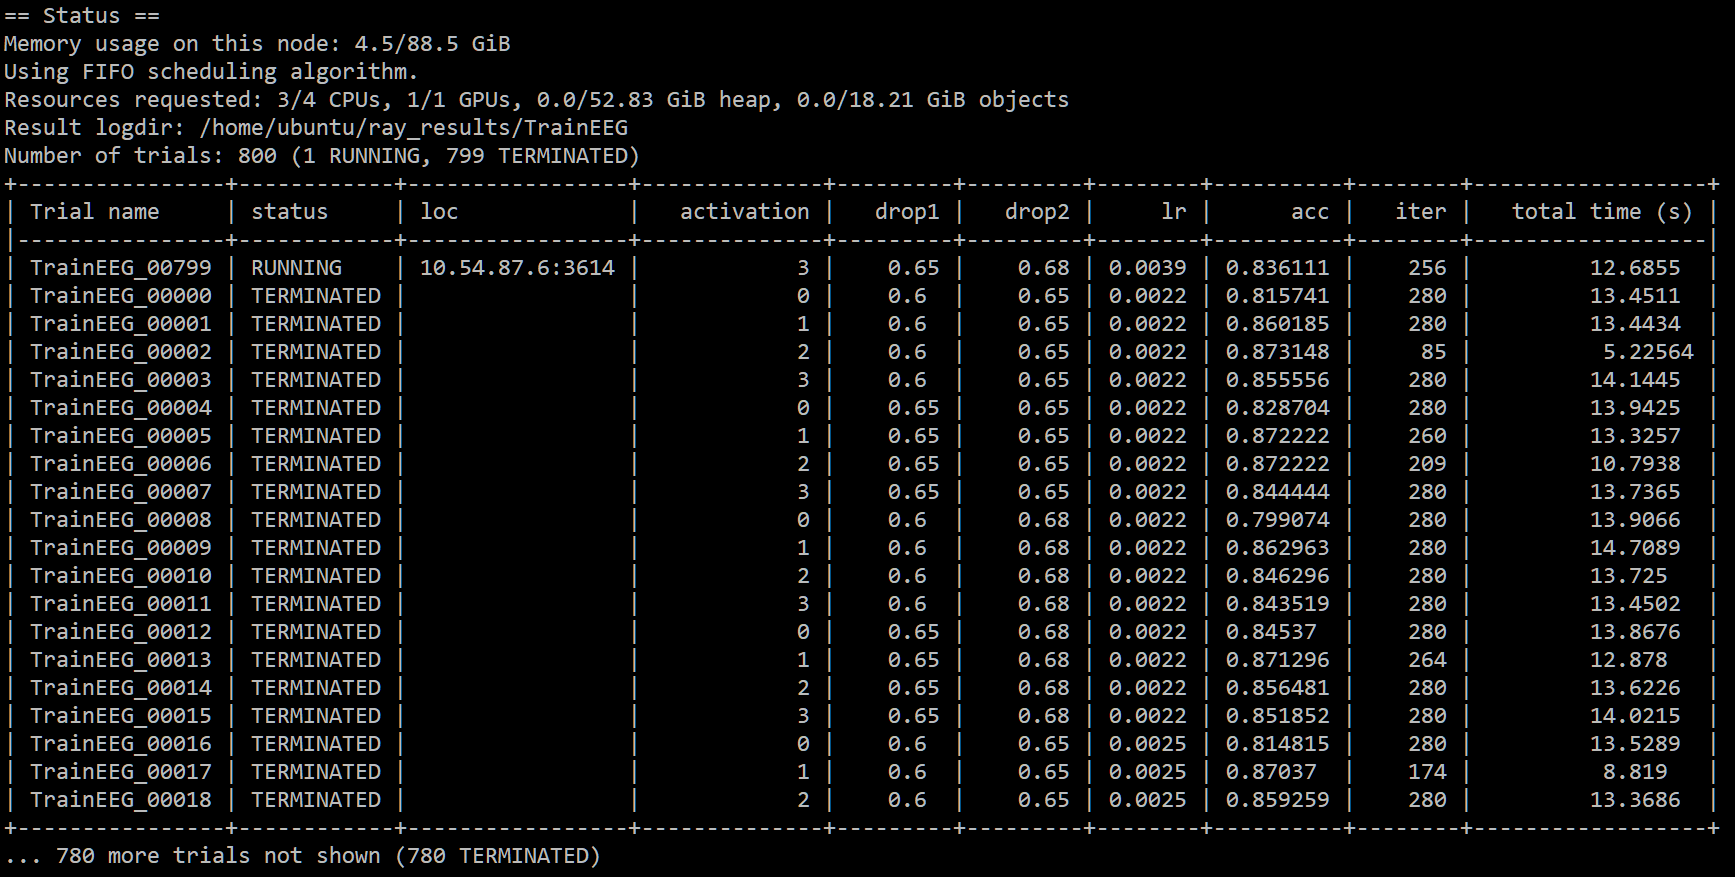

* Ray Tune result Example
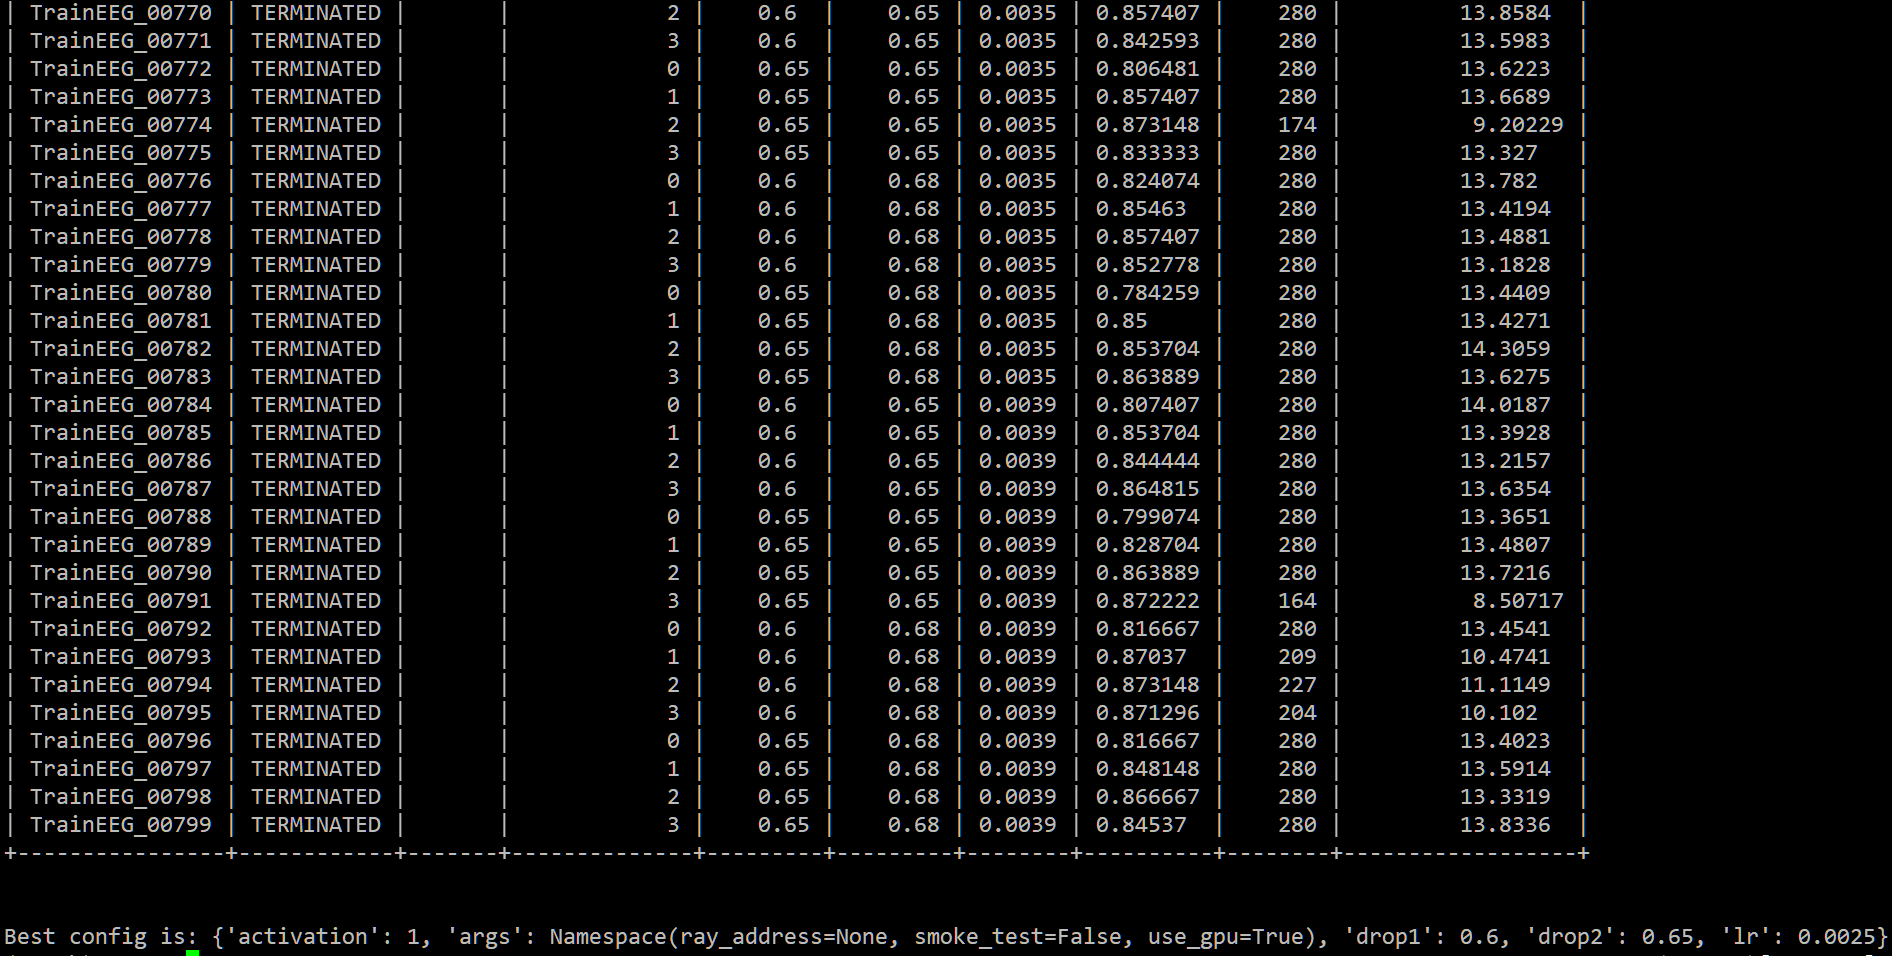

## Tuning Results
### Adam with weight decay
Due to the learning rate is set to be 0.0028, weight decay should be less than learning rate to improve optimization process.
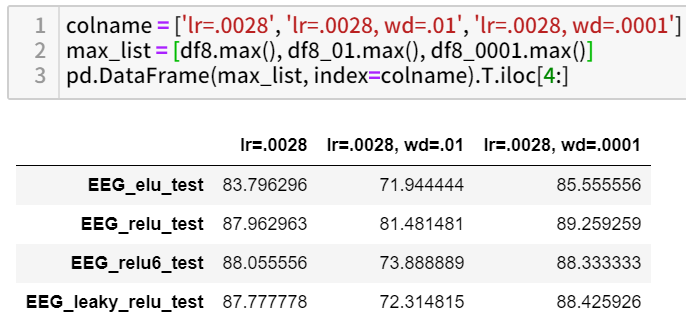

### Best hyperparameters
By Ray Tune, we get best learning rate between [0.0022 to 0.0028]. I apply the weight decay rate to be 0.001 to see whether it could be much better.
* Surprisingly, ELU performs usually bad, while ReLU6 often outperform ReLU.
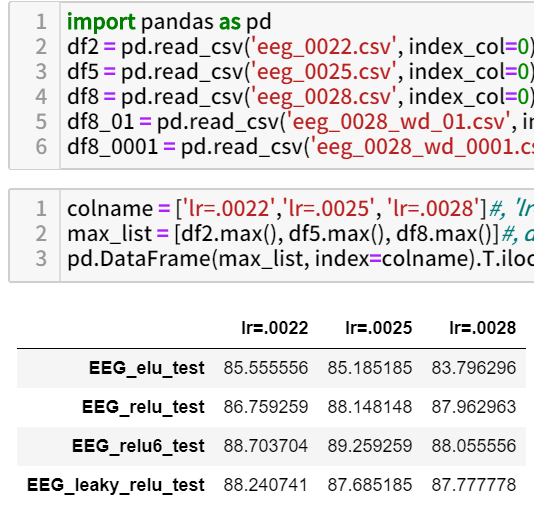
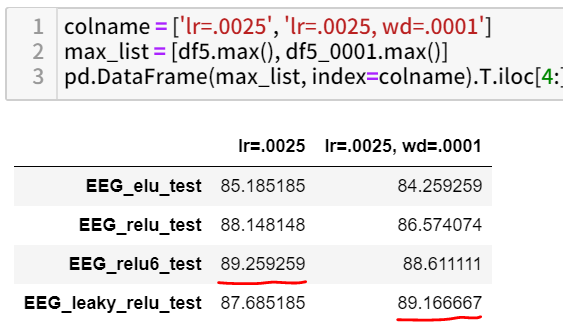


## Conclusion
EEGNet is an excellent network with efficient training time and good enough performance. Actually, the first version of EEGNet posted on arxiv at 2016 does not include Depthwise Separable Convolution. It is until the version3 and version4 at 2018 that EEGNet take some experiences from MobileNet and Xception so that this work become better. In EEG classification problem, or multi-channel time series classification, EEGNet is still state-of-the-art. However, I think EEGNet could be extended more, but maybe there are less researcher in BCI discipline working with it. Maybe some related works of Stock Market prediction, or some tricks in MobileNetV3 could apply on EEGNet to improve it. I would try this in my final project.

# Code
* For recording accuracy, we provide a `train` function and a `test` function in `main.py`
* In tuning process, it's not necessary to record accuracy of each epoch so that we provide simpler `train` function and `test` function in `EEGNet.py`

## main.py

In [ ]:
from functools import reduce

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim
import pandas as pd
from torch.cuda import device
from torch.utils.data import TensorDataset, DataLoader

from dataloader import read_bci_data
from EEGNet import EEGNet
from DCN2 import DeepConvNet

def get_bci_dataloaders():
    train_x, train_y, test_x, test_y = read_bci_data()
    datasets = []
    for train, test in [(train_x, train_y), (test_x, test_y)]:
        train = torch.stack(
            [torch.Tensor(train[i]) for i in range(train.shape[0])]
        )
        test = torch.stack(
            [torch.Tensor(test[i:i+1]) for i in range(test.shape[0])]
        )
        datasets += [TensorDataset(train, test)]

    return datasets

def get_data_loaders(train_dataset, test_dataset):
    #train_dataset, test_dataset = get_bci_dataloaders()
    kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
    return train_loader, test_loader


def showResult(title='', **kwargs):
    plt.figure(figsize=(15, 7))
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')

    for label, data in kwargs.items():
        plt.plot(range(len(data)), data, '--' if 'test' in label else '-', label=label)
    plt.ylim(0, 100)
    plt.xlim(0, 300)
    points = [(-5, 87), (310, 87)]
    (xpoints, ypoints) = zip(*points)

    plt.plot(xpoints, ypoints, linestyle='--', color='black')

    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.show()


    
def main():
    torch.backends.cudnn.enabled = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    nets1 = {
        "EEG_elu": EEGNet(nn.ELU).to(device),
        "EEG_relu": EEGNet(nn.ReLU).to(device),
        "EEG_relu6": EEGNet(nn.ReLU6).to(device),
        "EEG_leaky_relu": EEGNet(nn.LeakyReLU).to(device)
    }

    nets2 = {
            "DCN_elu": DeepConvNet(nn.ELU).to(device),
            "DCN_relu": DeepConvNet(nn.ReLU).to(device),
            "DCN_relu6": DeepConvNet(nn.ReLU6).to(device),
            "DCN_leaky_relu": DeepConvNet(nn.LeakyReLU).to(device)
    }
    
    #nets = nets1
    nets = nets2
    
    # Training setting
    loss_fn = nn.CrossEntropyLoss()
    learning_rates = {0.0025}

    optimizer = torch.optim.Adam
    optimizers = {
        key: optimizer(value.parameters(), lr=learning_rate, weight_decay=0.0001)
        for key, value in nets.items()
        for learning_rate in learning_rates
    }

    epoch_size = 300
    batch_size = 64
    acc = train(nets, epoch_size, batch_size, loss_fn, optimizers)
    df = pd.DataFrame.from_dict(acc)
    
    #df.to_csv('eeg_0025_0001.csv')
    #print(df)
    display(df)
    return df

# This train is for demo and recording accuracy
def train(nets, epoch_size, batch_size, loss_fn, optimizers):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    trainDataset, testDataset = get_bci_dataloaders()
    trainLoader, testLoader = get_data_loaders(trainDataset, testDataset)
    
    accuracy = {
        **{key + "_train": [] for key in nets},
        **{key + "_test": [] for key in nets}
    }
    for epoch in range(epoch_size + 1):
        train_correct = {key: 0.0 for key in nets}
        test_correct = {key: 0.0 for key in nets}
        for step, (x, y) in enumerate(trainLoader):
            x = x.to(device)
            y = y.to(device).long().view(-1)

            for key, net in nets.items():
                net.train(mode=True)
                y_hat = net(x)
                loss = loss_fn(y_hat, y)
                loss.backward()
                train_correct[key] += (torch.max(y_hat, 1)[1] == y).sum().item()

            for optimizer in optimizers.values():
                optimizer.step()
                optimizer.zero_grad()

        with torch.no_grad():
            for step, (x, y) in enumerate(testLoader):
                x = x.to(device)
                y = y.to(device).long().view(-1)
                for key, net in nets.items():
                    net.eval()
                    y_hat = net(x)
                    test_correct[key] += (torch.max(y_hat, 1)[1] == y).sum().item()

        for key, value in train_correct.items():
            accuracy[key + "_train"] += [(value * 100.0) / len(trainDataset)]

        for key, value in test_correct.items():
            accuracy[key + "_test"] += [(value * 100.0) / len(testDataset)]

        if epoch % 100 == 0:
            print('epoch : ', epoch, ' loss : ', loss.item())
            display(pd.DataFrame.from_dict(accuracy).iloc[[epoch]])
            print('')
        torch.cuda.empty_cache()
    showResult(title='Activation function comparison(EEGNet)'.format(epoch + 1), **accuracy)
    #showResult(title='Activation function comparison(DCN)'.format(epoch + 1), **accuracy)
    return accuracy

if __name__ == '__main__':
    df1 = main()
    df1.max()
    display(pd.DataFrame(df1.max(), columns=['best_acc']).T)

## EEGNet.py

In [ ]:
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from torch.cuda import device
from torch.utils.data import DataLoader

EPOCH_SIZE = 512
TEST_SIZE = 256

class EEGNet(nn.Module):
    def __init__(self, activation=None, dropout1=0.25, dropout2=0.25):
        if not activation:
            activation = nn.ELU
        super(EEGNet, self).__init__()

        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p=dropout1)
        )

        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=dropout2)
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
        )

    def forward(self, x):
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(-1, self.classify[0].in_features)
        x = self.classify(x)
        return x

# This train func is for tuning only so that accuracy recoding is removed
def train(model, optimizer, train_loader, device=torch.device("cpu")):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target.squeeze().long())
        loss.backward()
        optimizer.step()

# This test func is for tuning only so that accuracy recoding is removed
def test(model, test_loader, device=torch.device("cpu")):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
         for batch_idx, (data, target) in enumerate(test_loader):
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.squeeze().to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

## DCN.py

In [ ]:
from functools import reduce
import torch
import torch.nn as nn
import torch.optim as optim

class DeepConvNet(nn.Module):
    def __init__(self, activation=None, deepconv=[25,50,100,200], dropout=0.5):
        super(DeepConvNet, self).__init__()

        if not activation:
            activation = nn.ELU

        self.deepconv = deepconv
        self.conv0 = nn.Sequential(
            nn.Conv2d(
                1, deepconv[0], kernel_size=(1, 5),
                stride=(1,1), padding=(0,0), bias=True
            ),
            nn.Conv2d(
                deepconv[0], deepconv[0], kernel_size=(2,1),
                stride=(1,1), padding=(0,0), bias=True
            ),
            nn.BatchNorm2d(deepconv[0]),
            activation(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=dropout)
        )

        for idx in range(1, len(deepconv)):
            setattr(self, 'conv'+str(idx), nn.Sequential(
                nn.Conv2d(
                    deepconv[idx-1], deepconv[idx], kernel_size=(1,5),
                    stride=(1,1), padding=(0,0), bias=True
                ),
                nn.BatchNorm2d(deepconv[idx]),
                activation(),
                nn.MaxPool2d(kernel_size=(1, 2)),
                nn.Dropout(p=dropout)
            ))


        flatten_size =  deepconv[-1] * reduce(
            lambda x,_: round((x-4)/2), deepconv, 750)
        self.classify = nn.Sequential(
            nn.Linear(flatten_size, 2, bias=True),
        )

    def forward(self, x):
        for i in range(len(self.deepconv)):
            x = getattr(self, 'conv'+str(i))(x)
        # flatten
        x = x.view(-1, self.classify[0].in_features)
        x = self.classify(x)
        return x

## Tuning.py
This code should run in command line interface to get arguments

In [ ]:
from __future__ import print_function

import argparse
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from dataloader import read_bci_data
from EEGNet import (EEGNet, train, test)

import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler

activation_list = [nn.ELU, nn.ReLU, nn.ReLU6, nn.LeakyReLU]


def gen_bci_dataloaders():
    train_x, train_y, test_x, test_y = read_bci_data()
    datasets = []
    for train, test in [(train_x, train_y), (test_x, test_y)]:
        train = torch.stack(
            [torch.Tensor(train[i]) for i in range(train.shape[0])]
        )
        test = torch.stack(
            [torch.Tensor(test[i:i+1]) for i in range(test.shape[0])]
        )
        datasets += [TensorDataset(train, test)]

    return datasets

def get_data_loaders():
    train_dataset, test_dataset = gen_bci_dataloaders()
    kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
    return train_loader, test_loader

# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE = 512
TEST_SIZE = 256

# Training settings
parser = argparse.ArgumentParser(description="PyTorch MNIST Example")
parser.add_argument(    "--use-gpu",    action="store_true",    default=True,    help="enables CUDA training")
parser.add_argument(
    "--ray-address", type=str, help="The Redis address of the cluster.")
parser.add_argument(
    "--smoke-test", action="store_true", help="Finish quickly for testing")


class TrainEEG(tune.Trainable):
    def _setup(self, config):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.train_loader, self.test_loader = get_data_loaders()
        self.model = EEGNet(
                activation=activation_list[config.get("activation", 1)]).to(self.device)
                #dropout1=config.get("drop1", 0.6),
                #dropout2=config.get("drop2", 0.65)
                #).to(self.device)

        self.model = self.model.to(self.device)
        self.optimizer = optim.Adam(
                self.model.parameters(),
                lr=config.get("lr", 0.0025))

    def _train(self):
        train(
            self.model, self.optimizer, self.train_loader, device=self.device)
        acc = test(self.model, self.test_loader, self.device)
        return {"mean_accuracy": acc}

    def _save(self, checkpoint_dir):
        checkpoint_path = os.path.join(checkpoint_dir, "model.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        return checkpoint_path

    def _restore(self, checkpoint_path):
        self.model.load_state_dict(torch.load(checkpoint_path))



if __name__ == "__main__":
    return
    args = parser.parse_args()
    ray.init(address=args.ray_address, num_cpus=3 if args.smoke_test else None)
    #sched = ASHAScheduler(metric="mean_accuracy")


    analysis = tune.run(
        TrainEEG,
        #scheduler=sched,

        stop={
            "mean_accuracy": 0.87,
            "training_iteration": 3 if args.smoke_test else 300,
        },
        resources_per_trial={
            "cpu": 3,
            "gpu": int(args.use_gpu)
        },
        num_samples=1 if args.smoke_test else 10,
        checkpoint_at_end=True,
        checkpoint_freq=10,
        config={
            "activation": tune.grid_search([0, 1, 2, 3]),
            #"args": args,
            #"drop1": tune.grid_search([0.6,0.65]),
            #"drop2": tune.grid_search([0.65,0.68]),
            "lr": tune.grid_search([0.0025,0.0026])
            #"lr": tune.grid_search([0.0022,0.0025, 0.003, 0.01])
            #"lr": tune.uniform(0.0022, 0.005)
        })

    print("Best config is:", analysis.get_best_config(metric="mean_accuracy"))